In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import pandas as pd
from src.module import Module
import torch 
from src.dm import DataModule
import torchmetrics
from tqdm import tqdm
import numpy as np
import os 
from glob import glob

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [6]:
checkpoints = glob('./checkpoints/resnest50d*')
checkpoints

['./checkpoints/resnest50d_512-val_metric=0.63831-epoch=21.ckpt',
 './checkpoints/resnest50d_da-val_metric=0.63701-epoch=37.ckpt',
 './checkpoints/resnest50d_da-epoch=42.ckpt',
 './checkpoints/resnest50d_da-val_metric=0.19597-epoch=0.ckpt',
 './checkpoints/resnest50d_da-epoch=0.ckpt']

In [7]:
name = "resnest50d_512-val_metric=0.63831-epoch=21.ckpt"
checkpoint = f'./checkpoints/{name}'

In [12]:
# module = Module.load_from_checkpoint(checkpoint, map_location='cpu')

module = Module({
	't': 1, 
	'encoder': 'resnest50d', 
    'pretrained': False,
	'in_chans': 3,
    'loss': 'dice',
	'freeze': False,
})
state_dict = torch.load(checkpoint, map_location='cpu')['state_dict']
module.load_state_dict(state_dict)

<All keys matched successfully>

In [13]:
def eval(model, device=1):
	# dm = DataModule(false_color=True, t=[4], val_trans={'Resize': {"height":384, 'width':384}})
	dm = DataModule(false_color=True, t=[4], input_size=512)
	dm.setup()
	model.eval()
	model.cuda(device)
	metric = torchmetrics.Dice().cuda(device)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			y_hat = model(x.cuda(device))
			y_hat = torch.nn.functional.interpolate(y_hat, size=y.shape[-2:], mode='bilinear')
			metric(y_hat, y.cuda(device))
			pbar.set_description(f'Dice: {metric.compute().cpu().item():.5f}')

In [14]:
eval(module)

Dice: 0.63825: 100%|██████████| 116/116 [00:34<00:00,  3.35it/s]


In [8]:

module.cpu()
# module.eval() # ojo! que esto afecta al modelo exportado (eval/train)
module.train()

traced = torch.jit.trace(module.model, torch.rand(10, 384, 384, 1, 3))
# traced.save(f'kaggle-dataset/{name[:-5]}.pt')

/home/juan/.local/lib/python3.10/site-packages/einops/einops.py:316: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  known: Set[str] = {axis for axis in composite_axis if axis_name2known_length[axis] != _unknown_axis_length}
/home/juan/.local/lib/python3.10/site-packages/einops/einops.py:317: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  unknown: Set[str] = {axis for axis in composite_axis if axis_name2known_length[axis] == _unknown_axis_length}


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_12664/205772750.py:6 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_12664/205772750.py'                         │
│                                                                                                  │
│ /home/juan/.local/lib/python3.10/site-packages/torch/jit/_script.py:713 in save                  │
│                                                                                                  │
│    710 │   │   │                                                                                 │
│    711 │   │   │   See :func:`torch.jit.save <torch.jit.save>` for details.                      │
│    712 │   │   │   """                                                                           │
│ ❱  713 │   │   │   return self._c.save(str(f), **kwargs)                                         │
│    714 │   │                                                                                     │
│    715 │   │   def _save_for_lite_interpreter(self, *args, **kwargs):                            │
│    716 │   │   │   r"""                                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
loaded = torch.jit.load(f'kaggle-dataset/{name[:-5]}.pt')
loaded;

In [ ]:
# check traced model (debería dar parecido a antes de tracear)

eval(loaded)

Dice: 0.61688: 100%|██████████| 116/116 [00:39<00:00,  2.94it/s]


In [15]:
loaded = module

In [16]:
dm = DataModule(false_color=True, t=[4], input_size=512)
dm.setup()

loaded.eval()
loaded.cuda(1)

thresholds =  np.linspace(0.1, 0.9, 9)
dices, dices2 = [], []

for threshold in thresholds:
	metric = torchmetrics.Dice(threshold=threshold).cuda(1)
	metric2 = torchmetrics.Dice(threshold=threshold).cuda(1)
	with torch.no_grad():
		pbar = tqdm(dm.val_dataloader())
		for batch in pbar:
			x, y = batch
			y_hat = loaded(x.cuda(1))
			y_hat = torch.nn.functional.interpolate(y_hat, size=y.shape[-2:], mode='bilinear')
			#  put to zero all images with less than 10 pixels with value 1
			pr = torch.sigmoid(y_hat) > threshold
			metric(pr.float(), y.cuda(1))
			for item in range(pr.shape[0]):
				if torch.sum(pr[item]) < 10:
					pr[item] = torch.zeros_like(pr[item])
			metric2(pr.float(), y.cuda(1))
			pbar.set_description(f'Threshold: {threshold:.3f} Dice: {metric.compute().cpu().item():.5f} Dice (post): {np.mean(metric2).compute().cpu().item():.5f}')
	dices.append(metric.compute().cpu().item())
	dices2.append(metric2.compute().cpu().item())

data = pd.DataFrame({'threshold': thresholds, 'dice': dices, 'dice2': dices2})

  0%|          | 0/116 [00:00<?, ?it/s]

Threshold: 0.100 Dice: 0.63881 Dice (post): 0.63889: 100%|██████████| 116/116 [00:35<00:00,  3.30it/s]
Threshold: 0.200 Dice: 0.63859 Dice (post): 0.63865: 100%|██████████| 116/116 [00:45<00:00,  2.53it/s]
Threshold: 0.300 Dice: 0.63853 Dice (post): 0.63859: 100%|██████████| 116/116 [00:49<00:00,  2.35it/s]
Threshold: 0.400 Dice: 0.63840 Dice (post): 0.63846: 100%|██████████| 116/116 [00:52<00:00,  2.22it/s]
Threshold: 0.500 Dice: 0.63834 Dice (post): 0.63837: 100%|██████████| 116/116 [00:53<00:00,  2.15it/s]
Threshold: 0.600 Dice: 0.63827 Dice (post): 0.63830: 100%|██████████| 116/116 [00:55<00:00,  2.11it/s]
Threshold: 0.700 Dice: 0.63816 Dice (post): 0.63820: 100%|██████████| 116/116 [00:54<00:00,  2.12it/s]
Threshold: 0.800 Dice: 0.63797 Dice (post): 0.63802: 100%|██████████| 116/116 [00:56<00:00,  2.07it/s]
Threshold: 0.900 Dice: 0.63774 Dice (post): 0.63778: 100%|██████████| 116/116 [00:54<00:00,  2.14it/s]


In [17]:
data

,threshold,dice,dice2
0,0.1,0.638809,0.638892
1,0.2,0.638591,0.638649
2,0.3,0.638532,0.638595
3,0.4,0.638401,0.638459
4,0.5,0.638340,0.638367
5,0.6,0.638268,0.638295
6,0.7,0.638158,0.638200
7,0.8,0.637969,0.638020
8,0.9,0.637735,0.637782


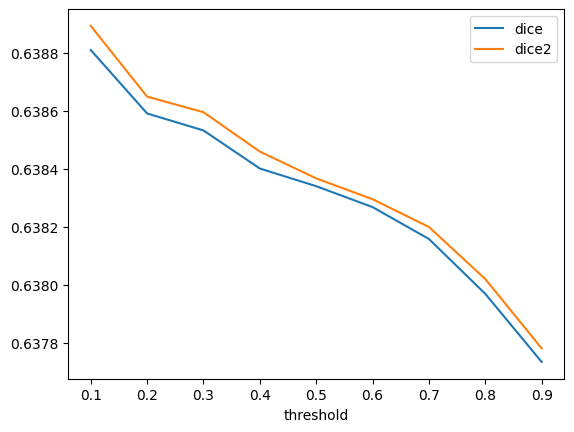

In [18]:
data.plot(x='threshold', y=['dice', 'dice2']);

In [17]:
# get threshold with max dice and dice2
data.loc[data['dice2'].idxmax()]

threshold    0.600000
dice         0.628039
dice2        0.628049
Name: 5, dtype: float64

In [18]:
path = Path('/fastdata/contrails')

records = os.listdir(path / 'test')
len(records)

2

In [19]:
stats = pd.read_csv(path/'stats.csv', index_col=0)
stats

,min,max,mean,std
8,175.82391,280.14868,233.67686,4.545741
9,180.74695,279.48690,242.25447,6.057177
10,181.44263,331.13394,250.75069,7.620164
11,179.33739,332.06036,274.41205,13.668153
12,187.69131,306.21823,255.52716,8.708825
13,179.34510,338.05670,276.60184,14.446373
14,178.71164,338.63330,275.35940,14.736154
15,178.36511,333.21048,272.56410,14.367307
16,137.39153,311.97977,260.42580,11.049050


In [20]:
import torch 
import numpy as np
import albumentations as A

def normalize_range(data, bounds):
    return (data - bounds[0]) / (bounds[1] - bounds[0])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, t=tuple(range(8)), path='/fastdata/contrails/test'):
        self.records = os.listdir(path)
        self.t = t 
        self.path = path

    def __len__(self):
        return len(self.records)
    
    def preprocess(self, record):
        _T11_BOUNDS = (243, 303)
        _CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
        _TDIFF_BOUNDS = (-4, 2)
        b11 = np.load(f'{self.path}/{record}/band_11.npy')[..., self.t]
        b14 = np.load(f'{self.path}/{record}/band_14.npy')[..., self.t]
        b15 = np.load(f'{self.path}/{record}/band_15.npy')[..., self.t]
        r = normalize_range(b15 - b14, _TDIFF_BOUNDS)
        g = normalize_range(b14 - b11, _CLOUD_TOP_TDIFF_BOUNDS)
        b = normalize_range(b14, _T11_BOUNDS)
        return np.clip(np.stack([r, g, b], axis=-1), 0, 1)
    
    def __getitem__(self, ix):
        record = self.records[ix]
        image = self.preprocess(record)
        H, W, T, C = image.shape
        image = image.reshape(image.shape[0], image.shape[1], -1)
        image = A.Resize(height=512, width=512)(image=image)['image']
        image = image.reshape(512, 512, T, C)
        return record, torch.from_numpy(image) # H, W, T, C

In [21]:
ds = Dataset([4])
dl = torch.utils.data.DataLoader(ds, batch_size=8, num_workers=4, pin_memory=True)

In [22]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

In [23]:
submission = {'record_id': [],	'encoded_pixels': []}

In [24]:
loaded.eval()
loaded.cuda(1)
with torch.no_grad():
    for records, x in dl:
        y_hat = loaded(x.cuda(1))
        probas = y_hat.sigmoid() > 0.5
        masks = torch.nn.functional.interpolate(probas.float(), size=[256,256], mode='bilinear')
        masks = masks.cpu().numpy().astype(np.int32)
        for ix in range(masks.shape[0]):
            mask = masks[ix][0] 
            if np.sum(masks[ix]) < 10:
                mask = np.zeros_like(mask)
            rle = rle_encode(mask)
            record = records[ix]
            submission['record_id'].append(record)
            if len(rle) == 0: 
                submission['encoded_pixels'].append('-')
            else:
                submission['encoded_pixels'].append(' '.join(map(str,rle)))

In [25]:
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv', index=False)
submission

,record_id,encoded_pixels
0,1002653297254493116,-
1,1000834164244036115,-


In [26]:
!kaggle datasets version -m "update" -p kaggle-dataset

Starting upload for file stats.csv
100%|████████████████████████████████████████████| 392/392 [00:01<00:00, 367B/s]
Upload successful: stats.csv (392B)
Starting upload for file fc_t5_seresnextaa101d_32x8d_512-val_metric=0.58112-epoch=72.pt
100%|████████████████████████████████████████| 536M/536M [00:12<00:00, 44.4MB/s]
Upload successful: fc_t5_seresnextaa101d_32x8d_512-val_metric=0.58112-epoch=72.pt (536MB)
Starting upload for file fc_t5_efficientnet_b0_da_512-val_metric=0.61805-epoch=293.pt
100%|██████████████████████████████████████| 16.8M/16.8M [00:02<00:00, 7.99MB/s]
Upload successful: fc_t5_efficientnet_b0_da_512-val_metric=0.61805-epoch=293.pt (17MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/juansensio/contrail-models
